<a href="https://colab.research.google.com/github/yonbrand/Gait-Recognition/blob/main/gait_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os 
import numpy as np
import pandas as pd
from numpy import genfromtxt

import pickle 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
#load the data
pd_pickle = open('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/classification_data/pd_gait.npy', "rb")
data_pd= pickle.load(pd_pickle)

labels_pd=np.ones((data_pd.shape[0],)) #PD patients classified as 1

hc_pickle = open('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/classification_data/hc_gait.npy', "rb")
data_hc= pickle.load(hc_pickle)
labels_hc=np.zeros((data_hc.shape[0],)) ##HC patients classify as 0


In [ ]:
all_data=np.append(data_pd,data_hc,axis=0)
with open('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/classification_data/all_data.npy', 'wb') as f:
    pickle.dump(all_data, f, protocol=4)

all_labels=np.append(labels_pd,labels_hc,axis=0)    
with open('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/classification_data/all_labels.npy', 'wb') as f:
    pickle.dump(all_labels, f, protocol=4)


In [ ]:
print(all_data.shape)
print(all_labels.shape)

(31338, 128, 3)
(31338,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.33, random_state=42)

In [ ]:
class LSTM(nn.Module):
  def __init__(self, n_inputs, n_steps, lstm_dim, num_layers):
      super(LSTM, self).__init__()

      self.linear = nn.Linear(n_inputs, lstm_dim)
      self.lstm = nn.LSTM(lstm_dim, lstm_dim, num_layers=num_layers, batch_first=True)
      
      self.n_layers = num_layers
      self.lstm_dim = lstm_dim
      self.n_steps = n_steps
      self.n_inputs = n_inputs
      
  def forward(self, x, h):

      n_batch, n_counts, n_input = list(x.size())
      #print(batch, n_counts, n_input)
      x = x.transpose(1, 0)
      #print(x.size())
      x = x.reshape(n_counts * n_batch, n_input)
      #print(x.size())
      x = self.linear(x)
      #print(x.size())
      x = x.reshape(n_counts , n_batch, self.lstm_dim)
      #print(x.size())

      out, (h, c) = self.lstm(x, h)

      return out[-1], (h, c)

  def init_states(self):
    weight = next(self.parameters()).data
    hidden = (weight.new(self.n_layers, self.n_steps, self.lstm_dim).zero_().to(device),
              weight.new(self.n_layers, self.n_steps, self.lstm_dim).zero_().to(device))
    return hidden

In [ ]:
class CNN(nn.Module):
  def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
      self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

      self.linear = nn.Linear(in_features=64*32*3, out_features=64)


  # define forward function
  def forward(self, x):

      n_batch, n_counts, n_input = list(x.size())

      x = x.reshape(n_batch, 1, n_counts, n_input)

      x = self.conv1(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=(2,1), stride=(2,1))
        
      x = self.conv2(x)
      x = F.elu(x)
      x = F.max_pool2d(x, kernel_size=(2,1), stride=(2,1))

      x = x.reshape(-1, 64*32*3)

      x = self.linear(x)
      x = F.elu(x)

      return x


In [ ]:
class Main(nn.Module):
    def __init__(self, CNNmodel, LSTMmodel):
        super().__init__()

        self.CNNmodel = CNNmodel
        self.LSTMmodel = LSTMmodel

        self.linear = nn.Linear(in_features=128, out_features=2)


    # define forward function
    def forward(self, x, states):

        x_cnn =  self.CNNmodel(x)

        # states = self.LSTMmodel.init_states()
        # states = tuple([e.data for e in states])
        x_lstm, states =  self.LSTMmodel(x, states)

        x = torch.cat([x_cnn, x_lstm], axis=1)

        out = self.linear(x)
        #out = torch.sigmoid(x)

        #out = out.reshape(-1)
        return out

    def init_states(self):
        return self.LSTMmodel.init_states()


In [ ]:
class GRU(nn.Module):
    def __init__(self, n_inputs, n_steps, gru_dim, num_layers):
        super(GRU, self).__init__()        
        
        self.linear = nn.Linear(n_inputs, gru_dim)
        self.gru = nn.GRU(gru_dim, gru_dim, num_layers=num_layers, batch_first=True)
      
        self.n_layers = num_layers
        self.gru_dim = gru_dim
        self.n_steps = n_steps
        self.n_inputs = n_inputs
      
    def forward(self, x, h):

      n_batch, n_counts, n_input = list(x.size())
      #print(batch, n_counts, n_input)
      x = x.transpose(1, 0)
      #print(x.size())
      x = x.reshape(n_counts * n_batch, n_input)
      #print(x.size())
      x = self.linear(x)
      #print(x.size())
      x = x.reshape(n_counts , n_batch, self.gru_dim)
      #print(x.size())

      out, h= self.gru(x, h)

      return out[-1], h

    def init_states(self):
      weight = next(self.parameters()).data
      hidden = (weight.new(self.n_layers, self.n_steps, self.gru_dim).zero_().to(device))
      return hidden

In [ ]:
class MainGRU(nn.Module):
    def __init__(self, CNNmodel, GRUmodel):
        super().__init__()

        self.CNNmodel = CNNmodel
        self.GRUmodel = GRUmodel

        self.linear = nn.Linear(in_features=128, out_features=2)


    # define forward function
    def forward(self, x, states):

        x_cnn =  self.CNNmodel(x)

        # states = self.GRUmodel.init_states()
        # states = tuple([e.data for e in states])
        x_gru, states =  self.GRUmodel(x, states)

        x = torch.cat([x_cnn, x_gru], axis=1)

        out = self.linear(x)
        #out = torch.sigmoid(x)

        #out = out.reshape(-1)
        return out

    def init_states(self):
        return self.GRUmodel.init_states()


In [ ]:
tensor_x_train = torch.Tensor(X_train).float() # transform to torch tensor
tensor_y_train = torch.Tensor(y_train).float()

train_dataset = TensorDataset(tensor_x_train,tensor_y_train) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # create your dataloader


tensor_x_test = torch.Tensor(X_test).float() # transform to torch tensor
tensor_y_test = torch.Tensor(y_test).float()

test_dataset = TensorDataset(tensor_x_test,tensor_y_test) # create your datset
test_dataloader = DataLoader(test_dataset, batch_size = batch_size) # create your dataloader

In [ ]:
learning_rate = 0.00001
batch_size = 64
display_step = 1


In [ ]:
n_inputs = 3 
n_steps = 128
n_epochs=100
lstm_dim = 64
layers = 2
LSTMmodel = LSTM(n_inputs, n_steps, lstm_dim, layers).to(device)

In [ ]:
CNNmodel = CNN().to(device)

In [ ]:
model = Main(CNNmodel, LSTMmodel).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
def check_acc(model, loader):
    correct = 0
    total = 0
    #TP=0
    #TN=0
    #FP=0
    #FN=0
    with torch.no_grad():
        for data in loader:
            states = model.init_states()
            features, labels = data
            states = tuple([e.data for e in states])
            outputs = model(features.to(device),states)
            _, predictions = outputs.max(1)
            total += labels.size(0)
            correct += torch.sum(predictions==labels.long().to(device))
            #TP+= ((predicted == labels) & (labels==1)).sum().item()
            #TN+=((predicted == labels) & (labels==0)).sum().item()
            #FP+=((predicted != labels) & (labels==0)).sum().item()
            #FN+=((predicted != labels) & (labels==1)).sum().item()
            
    acc = (100 * correct / total)
    #precision=100*(TP/(1+TP+FP))
    #sensitivity=100*(TP/(1+TP+FN))
    #specificity=100*(TN/(1+TN+FP))
    if loader=='train_dataloader':
      print('Accuracy on the training set is : %.3f %%' % acc)
    elif loader=='test_dataloader':
      print('Accuracy on the validation set is: %.3f %%' % acc)
    
    return acc

In [ ]:
main_path='/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/classification_model/'

In [ ]:
all_train_loss = []
all_test_loss = []
train_acc=[]
validation_acc=[]


for epoch in range(n_epochs):
      
  states = model.init_states()
  model.train()
  train_loss = []
  for batch_idx, (data, labels) in enumerate(train_dataloader):
    
    states = tuple([e.data for e in states])

    preds = model(data.to(device), states)

    #loss = F.cross_entropy(preds, labels.to(device))
    loss = criterion(preds, labels.long().to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    bach_loss = loss.item()

    train_loss.append(bach_loss)
    if batch_idx % 500 == 0:    
         print('[%d, %5d] loss: %.3f' %
               (epoch, batch_idx, bach_loss))
         
  epochloss = np.average(train_loss)
  all_train_loss.append(epochloss)
  #model.eval()

  print("epoch %d,  train loss : %.3f," % (epoch, epochloss))  

  train_acc.append( check_acc(model, train_dataloader) )
  validation_acc.append( check_acc(model, test_dataloader) )
  with open('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/classification_model/train_acc.npy', 'wb') as f:
    pickle.dump(train_acc, f, protocol=4)
  with open('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/classification_model/validation_acc.npy', 'wb') as f:
    pickle.dump(validation_acc, f, protocol=4)
  torch.save(model.state_dict(), main_path+ 'gait_classification_'+ str(epoch) +'.pt') #saving the trained model   

[0,     0] loss: 0.597
epoch 0,  train loss : 0.604,
[1,     0] loss: 0.613
epoch 1,  train loss : 0.603,
[2,     0] loss: 0.598
epoch 2,  train loss : 0.601,
[3,     0] loss: 0.584
epoch 3,  train loss : 0.599,
[4,     0] loss: 0.507
epoch 4,  train loss : 0.599,
[5,     0] loss: 0.535
epoch 5,  train loss : 0.598,
[6,     0] loss: 0.672
epoch 6,  train loss : 0.597,
[7,     0] loss: 0.592
epoch 7,  train loss : 0.595,
[8,     0] loss: 0.561
epoch 8,  train loss : 0.595,
[9,     0] loss: 0.666
epoch 9,  train loss : 0.593,
[10,     0] loss: 0.534
epoch 10,  train loss : 0.592,
[11,     0] loss: 0.623
epoch 11,  train loss : 0.592,
[12,     0] loss: 0.752
epoch 12,  train loss : 0.589,
[13,     0] loss: 0.600
epoch 13,  train loss : 0.589,
[14,     0] loss: 0.607
epoch 14,  train loss : 0.587,
[15,     0] loss: 0.532
epoch 15,  train loss : 0.587,
[16,     0] loss: 0.629
epoch 16,  train loss : 0.586,
[17,     0] loss: 0.587
epoch 17,  train loss : 0.586,
[18,     0] loss: 0.593
epoch 

In [ ]:
torch.save(model.state_dict(), main_path+'gait_classification.pt') #saving the trained model  

Text(0, 0.5, 'accuracy')

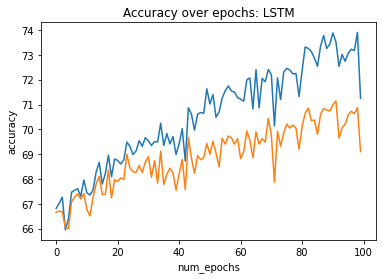

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_acc)),train_acc)
plt.plot(range(len(train_acc)),validation_acc)
plt.title('Accuracy over epochs: LSTM')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')


Text(0, 0.5, 'loss')

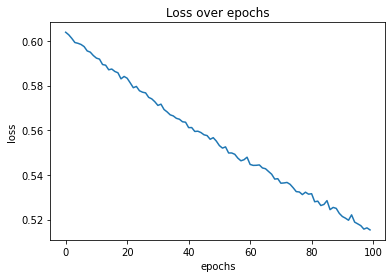

In [ ]:
plt.plot(all_train_loss)
plt.title('Loss over epochs')
plt.xlabel('epochs')
plt.ylabel('loss')

Training with GRU

In [ ]:
n_inputs = 3 
n_steps = 128
n_epochs=100
gru_dim = 64
layers = 2
GRUmodel = GRU(n_inputs, n_steps, gru_dim, layers).to(device)

In [ ]:
model = MainGRU(CNNmodel, GRUmodel).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
def check_acc(model, loader):
    correct = 0
    total = 0
    #TP=0
    #TN=0
    #FP=0
    #FN=0
    with torch.no_grad():
        for data in loader:
            states = model.init_states()
            features, labels = data
            states = states.data
            outputs = model(features.to(device),states)
            _, predictions = outputs.max(1)
            total += labels.size(0)
            correct += torch.sum(predictions==labels.long().to(device))
            #TP+= ((predicted == labels) & (labels==1)).sum().item()
            #TN+=((predicted == labels) & (labels==0)).sum().item()
            #FP+=((predicted != labels) & (labels==0)).sum().item()
            #FN+=((predicted != labels) & (labels==1)).sum().item()
            
    acc = (100 * correct / total)
    #precision=100*(TP/(1+TP+FP))
    #sensitivity=100*(TP/(1+TP+FN))
    #specificity=100*(TN/(1+TN+FP))
    if loader=='train_dataloader':
      print('Accuracy on the training set is : %.3f %%' % acc)
    elif loader=='test_dataloader':
      print('Accuracy on the validation set is: %.3f %%' % acc)
    
    return acc

In [ ]:
all_train_loss_gru = []
train_acc_gru=[]
validation_acc_gru=[]


for epoch in range(n_epochs):
      
  states = model.init_states()
  model.train()
  train_loss = []
  for batch_idx, (data, labels) in enumerate(train_dataloader):
    
    states = states.data

    preds = model(data.to(device), states)

    #loss = F.cross_entropy(preds, labels.to(device))
    loss = criterion(preds, labels.long().to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    bach_loss = loss.item()

    train_loss.append(bach_loss)
    if batch_idx % 500 == 0:    
         print('[%d, %5d] loss: %.3f' %
               (epoch, batch_idx, bach_loss))
         
  epochloss = np.average(train_loss)
  all_train_loss_gru.append(epochloss)
  #model.eval()

  print("epoch %d,  train loss : %.3f," % (epoch, epochloss))  

  train_acc_gru.append( check_acc(model, train_dataloader) )
  validation_acc_gru.append( check_acc(model, test_dataloader) )

   

[0,     0] loss: 0.681
epoch 0,  train loss : 0.603,
[1,     0] loss: 0.571
epoch 1,  train loss : 0.594,
[2,     0] loss: 0.563
epoch 2,  train loss : 0.589,
[3,     0] loss: 0.559
epoch 3,  train loss : 0.584,
[4,     0] loss: 0.598
epoch 4,  train loss : 0.580,
[5,     0] loss: 0.588
epoch 5,  train loss : 0.574,
[6,     0] loss: 0.610
epoch 6,  train loss : 0.573,
[7,     0] loss: 0.668
epoch 7,  train loss : 0.569,
[8,     0] loss: 0.538
epoch 8,  train loss : 0.567,
[9,     0] loss: 0.547
epoch 9,  train loss : 0.564,
[10,     0] loss: 0.543
epoch 10,  train loss : 0.561,
[11,     0] loss: 0.519
epoch 11,  train loss : 0.559,
[12,     0] loss: 0.592
epoch 12,  train loss : 0.557,
[13,     0] loss: 0.546
epoch 13,  train loss : 0.555,
[14,     0] loss: 0.585
epoch 14,  train loss : 0.553,
[15,     0] loss: 0.541
epoch 15,  train loss : 0.552,
[16,     0] loss: 0.587
epoch 16,  train loss : 0.550,
[17,     0] loss: 0.562
epoch 17,  train loss : 0.548,
[18,     0] loss: 0.567
epoch 

In [ ]:
  with open('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/classification_model/train_acc_gru.npy', 'wb') as f:
    pickle.dump(train_acc_gru, f, protocol=4)
  with open('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/classification_model/validation_acc_gru.npy', 'wb') as f:
    pickle.dump(validation_acc_gru, f, protocol=4)

Text(0, 0.5, 'accuracy')

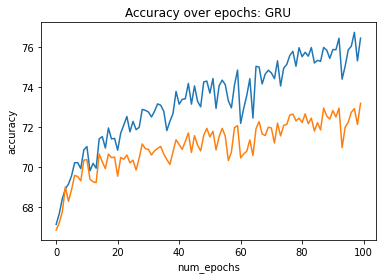

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_acc)),train_acc_gru)
plt.plot(range(len(train_acc)),validation_acc_gru)
plt.title('Accuracy over epochs: GRU')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')


Text(0, 0.5, 'loss')

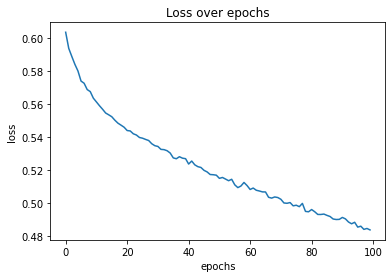

In [ ]:
plt.plot(all_train_loss_gru)
plt.title('Loss over epochs')
plt.xlabel('epochs')
plt.ylabel('loss')